In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
import seaborn as sns
import numpy as np
np.random.seed(0)

# Psychopathy

You are interested in causes and treatment options for psychopathy. You obtained a dataset, contained in the file psychopathy.mat obtained from a prison for violent offenders in upstate New York (not everyone in the prison is a psychopath, but they are more prevalent than in the general population). All study participants underwent a structural scan with a mobile, truck-mounted MRI. Each row of the matrix represents data from one prisoner. The first column contains the estimated cortical volume of paralimbic areas, relative to the population median, in cm3. The second column contains the Hare Psychopathy Checklist (PCL-R) scores, which range from 0 to 40 (the higher the score, the more psychopathic traits someone exhibits). These scores are not distributed normally in either the general population (median = 4) or this prison subpopulation (median = 20). The third column indicates whether they already participated in an experimental treatment program known as “decompression therapy” (0 = did not yet participate, 1 = did already participate). To avoid self-selection effects, everyone in this dataset agreed to the therapy, but prisoners were randomly assigned to an earlier and a later treatment group, so that the untreated prisoners could serve as a control group.

In [2]:
X = loadmat('psychopathy.mat')['DATA']
df = pd.DataFrame(X)
df.index.name = 'subject'
df.columns.name = 'measurement'
df.columns = ['paralimbic_vol', 'pclr_score', 'treated']
df = df.astype({'pclr_score': int, 'treated': bool})
display(df.sample(5))

,paralimbic_vol,pclr_score,treated
subject,,,
26,-1.924975,21,False
27,-1.140256,27,False
48,1.202118,21,False
22,1.254971,10,True
30,-1.017219,15,True


# a)

Use polynomial regression to model PCL-R scores as a function of relative volume of paralimbic areas. (Note, you might make use of your code from HW2.) Use cross-validation to determine the best polynomial degree.

In [3]:
def fit(X, y):
    U, S, Vt = np.linalg.svd(X)
    inds = np.arange(X.shape[1])
    S_inv = np.zeros((X.shape[1], X.shape[0]))
    S_inv[inds, inds] = 1 / S
    X_inv = np.dot(Vt.T, np.dot(S_inv, U.T))
    beta = np.squeeze(np.dot(X_inv, y))
    return beta

In [4]:
def design_matrix(x, order=1):
    n = len(x)
    X = []
    for i in range(order + 1):
        X.append(x ** i)
    return np.concatenate([X]).T

Run a leave-one-out cross-validation round on every sample in the dataset. We will average MSE across these runs to estimate generalization error for solutions of each order.

In [5]:
def hold_one_split(X, y, i):
    return x.drop(index=i), y.drop(index=i), x.loc[i], y.loc[i]

In [6]:
x = df.paralimbic_vol
y = df.pclr_score
orders = pd.Series([1, 2, 3, 4, 5], name='order')
mse = np.zeros((len(x), 5))
for i in range(len(x)):
    x_train, x_test, y_train, y_test = hold_one_split(x, y, i)
    for order in orders:
        X_train = design_matrix(x_train, order=order)
        X_test = design_matrix(x_test, order=order)
        beta = fit(X_train, y_train)
        y_pred = X_test @ beta
        mse[i, order - 1] = np.mean((y_pred - y_test) ** 2)

MSE measured over $k$-fold cross-validation, where $k$ is the number of samples in the dataset:

In [7]:
display(pd.DataFrame(mse, columns=orders).describe().iloc[1:3])

order,1,2,3,4,5
mean,521.373184,606.884811,51080.329123,3.871023e+07,2.490201e+10
std,338.264853,380.468207,43551.055231,3.366031e+07,2.165602e+10


The first-order polynomial fits the target best, as it has the lowest averaged leave-one-out MSE (521). The standard deviation of these MSEs (for MSE is itself a random variable) is also the lowest for order 1.

However, the MSE estimates for orders 1 and 2 are somewhat overlapping (note their standard deviation). So I'm not sure how confident we should be in using it for model selection.

# b)

Use bootstrapping methods to estimate the 95% confidence interval of the average paralimbic volume of the decompression treatment group vs. the control group. If the random assignment worked, the confidence intervals should overlap. Do they? Also, do these data suggest that there is a statistically reliable difference from the general population, in terms of paralimbic volume?

In [8]:
treated = df[df.treated]
untreated = df[~df.treated]

treated_avgs = np.zeros(500)
untreated_avgs = np.zeros(500)
for i in range(500):
    treated_resampled = treated.sample(len(treated), replace=True)
    untreated_resampled = untreated.sample(len(untreated), replace=True)
    treated_avgs[i] = treated_resampled.paralimbic_vol.mean()
    untreated_avgs[i] = untreated_resampled.paralimbic_vol.mean()

confidence = np.quantile(treated_avgs, [0.05, 0.95])
print(f"Treated 95% confidence interval: [{confidence[0]}, {confidence[1]}]")
confidence = np.quantile(untreated_avgs, [0.05, 0.95])
print(f"Untreated 95% confidence interval: [{confidence[0]}, {confidence[1]}]")

Treated 95% confidence interval: [-1.3100843375340006, -0.7767115288206876]
Untreated 95% confidence interval: [-1.0208844831583854, -0.22635649292108395]


The confidence intervals overlap. We may interpret these data as saying that with 95% certainty, the true values for average treated and untreated relative paralimbic volume are between [-1.3 and -0.78] and [-1.0 and -0.23], respectively. This means that for both treated and untreated, there is <5% probability that the true value is greater than or equal to 0. In other words, if in fact there is no statistically reliable difference, we have <5% probability of incorrectly concluding there is a difference (rejecting the null hypothesis). This is equivalent to a p-value <0.05, meeting a conventional criterion for "statistical significance".

However, I note that it is difficult to reason properly about statistical differences without access to the full distribution of paralimbic measurements from the general population. We only have access to a point estimate (the median) of the general population's paralimbic volume. Imagine that variability in the general population is already much greater than the widths of our confidence intervals. We do not know whether this is the case. If so, I doubt these confidence intervals should be interpreted as "statistically reliable".

# c)

Do a permutation test to assess whether decompression therapy has an effect. Designate an appropriate test statistic and calculate its p-value.

We have already split the dataset into `treated` and `untreated` groups. We will test whether the difference in mean PCL-R score between the treated and untreated group is significantly greater than the expected difference in mean PCL-R scores for two equal-sized groups randomly sampled from the whole population.

In [9]:
diffs = np.zeros(10000)
for i in range(10000):
    pooled = pd.concat([treated, untreated])
    shuffled = pooled.sample(len(pooled), replace=False)
    group1 = shuffled.iloc[:len(pooled) // 2]
    group2 = shuffled.iloc[len(pooled) // 2:]
    mean1 = group1.pclr_score.mean()
    mean2 = group2.pclr_score.mean()
    diffs[i] = np.abs(mean2 - mean1)

Here is the distribution of differences for two groups randomly sampled from the population:

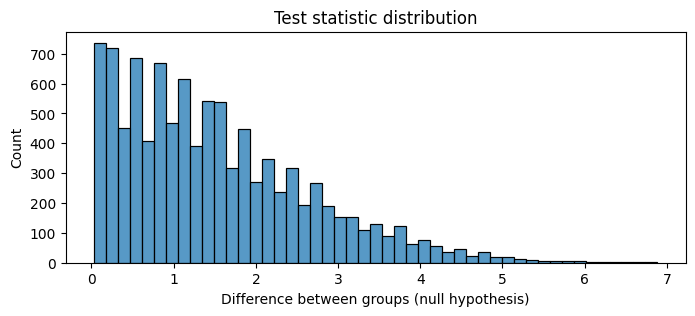

In [10]:
plt.subplots(figsize=(8, 3))
plt.title('Test statistic distribution')
plt.ylabel('Count')
plt.xlabel('Difference between groups (null hypothesis)')
sns.histplot(diffs)
plt.show()

Now we compute mean PCL-R scores for the treated and untreated groups separately, and compare this difference to our null statistic.

In [11]:
mean_treated = treated.pclr_score.mean()
mean_untreated = untreated.pclr_score.mean()
treatment_diff = mean_untreated - mean_treated
print(f"Treatment difference: {treatment_diff}")

Treatment difference: 3.2285714285714278


How likely is it that a random sample drawn from the test statistic will exceed this difference value? We can simply ask what proportion of samples exceeded this value in our permutation test. That is our p-value.

In [12]:
p = np.sum(diffs > treatment_diff) / len(diffs)
p

0.0882

Our p-value exceeds 0.08. So, by conventional standards the decompression therapy **does not** have a statistically significant effect.